## Exporting yolov8 model to Pytorch Mobile

WARNING: the following export was done using the [ultralytics yolov8 code](https://github.com/ultralytics/ultralytics), and the necessary adaptations were made so it would work in the Pytorch official [iOS demo app](https://github.com/pytorch/ios-demo-app/tree/master/ObjectDetection).

In this script we're more interested in the smallest model, the yolov8n, but it should work fine for larger ones.


### 1. Install requirements

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import os
import sys
import json

import ipyplot
import cv2
import numpy as np

import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import utils

### 2. Export Pytorch model to torchscript for mobile using `ultralytics` script

The following will download the .pt model (if necessary) and convert to the mobile format.

In [4]:
MODEL_NAME = "yolov8n"
from ultralytics import YOLO

# Load a model
model = YOLO(f"{MODEL_NAME}.pt")  # load an official model

# Export the model
model.export(format="torchscript", optimize=True)

print(f"{MODEL_NAME} model exported!")

Ultralytics YOLOv8.2.62 🚀 Python-3.10.14 torch-2.3.1 CPU (Apple M3)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

TorchScript: starting export with torch 2.3.1...
TorchScript: optimizing for mobile...
TorchScript: export success ✅ 1.1s, saved as 'yolov8n.torchscript' (12.2 MB)

Export complete (1.6s)
Results saved to /Users/gustavofuhr/projects/object_detection_ios_comprehensive/yolov5_yolov8_ultralytics_to_pytorch_mobile
Predict:         yolo predict task=detect model=yolov8n.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolov8n.torchscript imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
yolov8n model exported!


### 3. Inference using torchscript model 

If the above worked as expected, you should have in the current dir the original Pytorch yolov8 model `yolov8n.pt` and the converted one `yolov8n.torchscript`.We will use this converted model bellow to make inferences, using the ultralytics package (the easy way) and pytorch directly (the more interesting way).

#### a) Run the model using the ultralytics package

Loading yolov8n.torchscript for TorchScript inference...

0: 640x640 2 persons, 1 tie, 79.4ms
Speed: 1.5ms preprocess, 79.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)



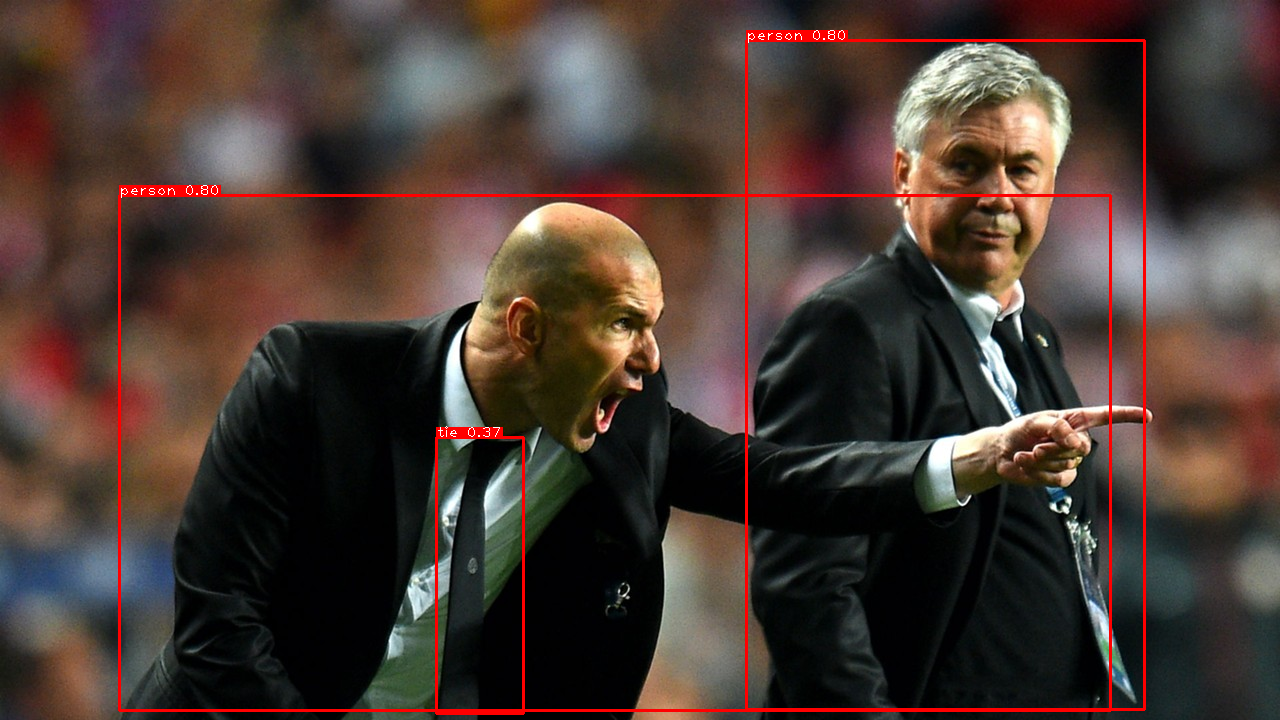


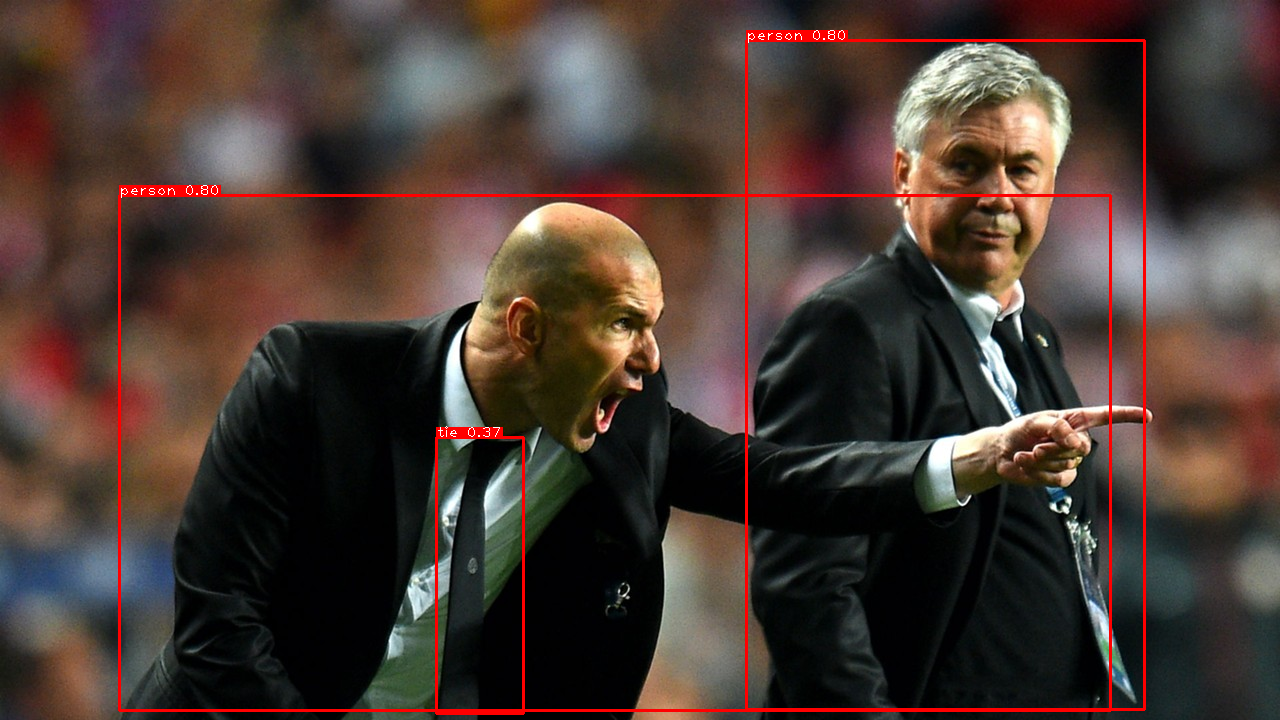

In [5]:
def ultralytics_postprocess(results):
    # Postprocess the results coming from ultralytics    
    dets = []
    for det in results[0].boxes:
        det = {
            "box": det.xyxy[0].numpy(),
            "label": results[0].names[int(det.cls)],
            "score": det.conf.item(),
        }
        dets.append(det)

    return dets

model = YOLO(f"{MODEL_NAME}.torchscript", task="detect")  # pretrained YOLOv8n model

results = model(["../sample_images/zidane.jpg"])
# results[0].boxes

im = results[0].orig_img
ipyplot.plot_images(images=[utils.plot_detections(im, ultralytics_postprocess(results))], 
                        labels=[f"{MODEL_NAME} detections using ultralytics package"], img_width=700)

### b) Inference using only Pytorch

It's crucial that, if we want to use the torchscript in an app, we understand how the image preprocessing is done. This usually means a crop/resize policy, converting to tensor, normalization, etc. It's also important that we understand the output that the model itself is returning so that we can postprocess these in our app code.

In [6]:
import torch

model_file = f"{MODEL_NAME}.torchscript"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the torchscript model
extra_files = {"config.txt": ""}  # model metadata
model = torch.jit.load(model_file, _extra_files=extra_files, map_location=device)
if extra_files["config.txt"]:  # load metadata dict
    metadata = json.loads(extra_files["config.txt"], object_hook=lambda x: dict(x.items()))
model

RecursiveScriptModule(original_name=DetectionModel)

In [7]:

def yolov8_preprocess(image, target_size=(640, 640)):
    # First thing is to resize the image into letterbox format
    im, lb_offset = utils.resize_keep_ratio(image, target_size, padding = True, letter_box = True)
    x = np.stack([im])
    x = x[..., ::-1].transpose((0, 3, 1, 2))  # BGR to RGB, BHWC to BCHW, (n, 3, h, w)
    x = np.ascontiguousarray(x)  # contiguous
    x = torch.from_numpy(x)

    x = x.to(device)
    x = x.float()  # uint8 to fp16/32
    x /= 255
    
    return x, lb_offset


image = cv2.imread("../sample_images/zidane.jpg")
original_image = image.copy() # save for visualization

input_tensor, lb_offset = yolov8_preprocess(image)



(0, 140)


In [8]:
results = model.forward(input_tensor)
print(results.shape)
results

torch.Size([1, 84, 8400])


tensor([[[3.4119e+00, 1.8456e+01, 2.3508e+01,  ..., 5.3304e+02, 5.4727e+02, 5.7386e+02],
         [1.5456e+01, 1.0316e+01, 7.2493e+00,  ..., 5.8071e+02, 5.8180e+02, 5.8796e+02],
         [7.2889e+00, 3.7385e+01, 4.8357e+01,  ..., 2.2682e+02, 1.9920e+02, 1.6756e+02],
         ...,
         [2.7295e-07, 1.9863e-07, 2.3292e-07,  ..., 5.4578e-07, 5.4567e-07, 1.0634e-06],
         [1.6954e-07, 1.7090e-07, 1.0958e-07,  ..., 1.0206e-06, 9.8977e-07, 1.1917e-06],
         [2.7436e-07, 1.1194e-07, 8.7628e-08,  ..., 1.2448e-06, 1.1104e-06, 1.3613e-06]]])

Now it's the time of post-processing the model's output (without the ultralytics code). Nowadays, single-stage detectors models are set to return a fixed number of bounding boxes, with associated classes and scores. Usually, most of the boxes are rejected since they have very small scores or in the NMS stage. Sometimes the NMS is added in the model itself (which is cool imho), but here it's not the case.

The following code is taken from the examples in `third_party/ultralytics/examples/`


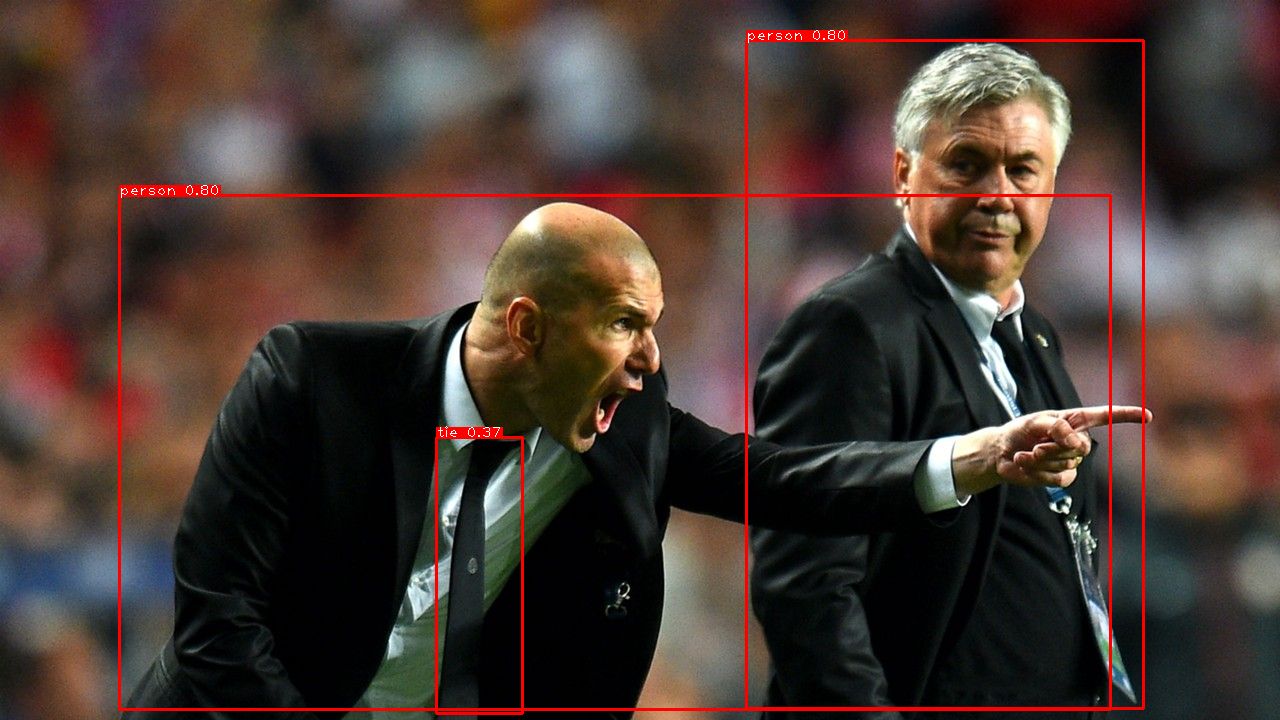


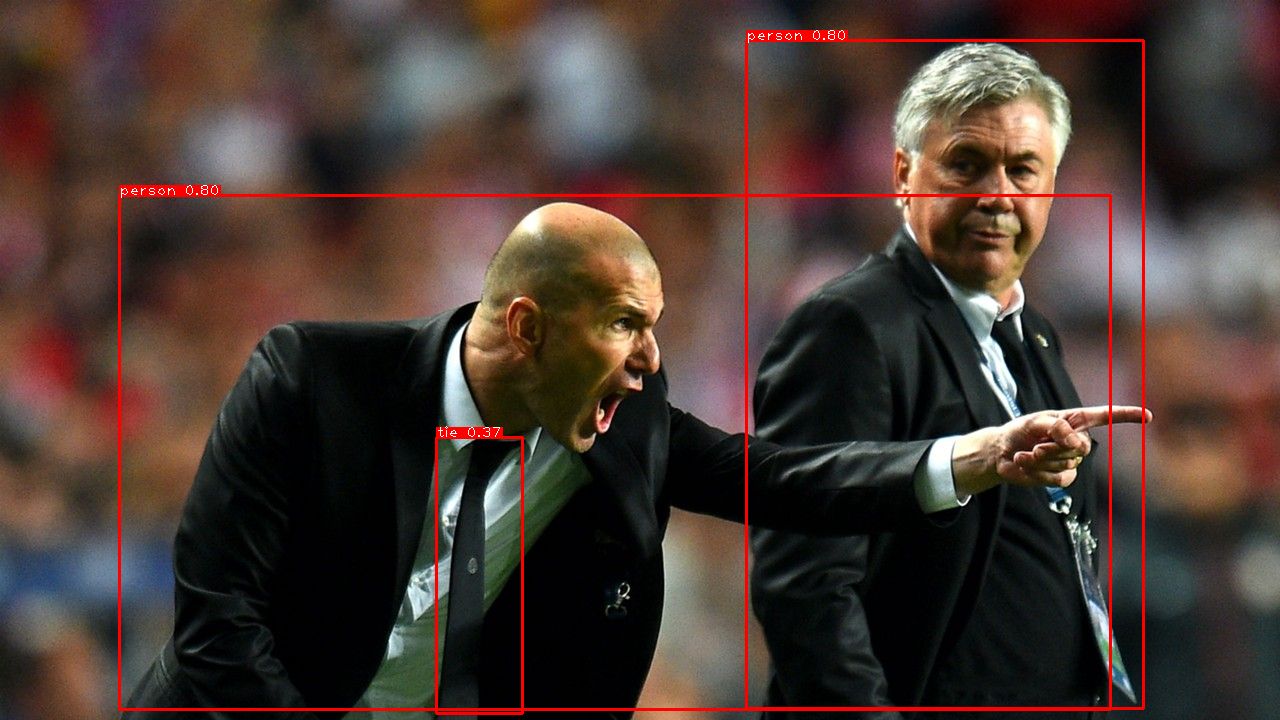

In [9]:
def yolov8_postprocess(results, lb_offset=(0, 0)):

    results = np.transpose(np.squeeze(results[0])) # assuming a single image/output
    rows = results.shape[0]

    # Lists to store the bounding boxes, scores, and class IDs of the detections
    boxes, scores, class_ids = [], [], []

    # Calculate the scaling factors for the bounding box coordinates
    x_factor = original_image.shape[1] / (640 - 2*lb_offset[0])
    y_factor = original_image.shape[0] / (640 - 2*lb_offset[1])

    conf_threshold = 0.3

    # Iterate over each row in the outputs array
    for i in range(rows):
        # Extract the class scores from the current row
        classes_scores = results[i][4:]

        max_score = np.amax(np.array(classes_scores))

        # If the maximum score is above the confidence threshold
        if max_score >= conf_threshold:
            # Get the class ID with the highest score
            class_id = np.argmax(classes_scores)

            # Extract the bounding box coordinates from the current row
            x, y, w, h = results[i][0], results[i][1], results[i][2], results[i][3]
            x -= lb_offset[0]
            y -= lb_offset[1]

            left = int((x - w / 2) * x_factor)
            top = int((y - h / 2) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)

            class_ids.append(class_id)
            scores.append(max_score)
            boxes.append([left, top, width, height])

    # Apply non-maximum suppression to filter out overlapping bounding bo
    indices = cv2.dnn.NMSBoxes(boxes, scores, conf_threshold, 0.5)

    detections = []
    for i in indices:
        xyxy_box = [boxes[i][0], boxes[i][1], boxes[i][0] + boxes[i][2], boxes[i][1] + boxes[i][3]]
        detections.append({
            "box": xyxy_box,
            "score": scores[i],
            "label": metadata["names"][str(class_ids[i].item())]
        })

    return detections

ipyplot.plot_images(images=[utils.plot_detections(original_image, yolov8_postprocess(results, lb_offset=lb_offset))], 
                        labels=[f"{MODEL_NAME} detections using the above code (only pytorch)"], img_width=700)

### 4. Setup the demo app (still doing)

Right now, we now what we need to do as pre and post processing for the torchscript mobile module. If we can replicate it in the iOS app that should work as above.

#### Clone if doesn't exists

In [ ]:
DEMO_DIR = "third_party/pytorch-ios-demo-app"
!git -C {TARGET_DIR} pull || git clone https://github.com/pytorch/ios-demo-app {DEMO_DIR}

fatal: cannot change to '{TARGET_DIR}': No such file or directory
fatal: destination path '{DEMO_DIR}' already exists and is not an empty directory.


#### Install pods 
(IMPORTANT!) The version of the Lib-Torch specified in the Podfile will not work in the current version of the model/exporter. So we need to patch it.

In [ ]:

import os

with open(f"{DEMO_DIR}/ObjectDetection/Podfile", "r") as f, \
        open(f"{DEMO_DIR}/ObjectDetection/Podfile_fixed_for_yolov8", "w") as f_out:
    content = f.readlines()
    for ln in content:
        if "LibTorch-Lite" in ln:
            ln = "  pod 'LibTorch-Lite', '~>1.2'\n"
        f_out.write(ln)

os.rename(f'{DEMO_DIR}/ObjectDetection/Podfile_fixed_for_yolov8', f'{DEMO_DIR}/ObjectDetection/Podfile')
print("Podfile updated")

Podfile updated


In [ ]:
!cd {DEMO_DIR}/ObjectDetection && pod install

Analyzing dependencies
Installing LibTorch-Lite 1.13.0.1 (was 2.1.0)
Generating Pods project
Integrating client project
Pod installation complete! There is 1 dependency from the Podfile and 1 total pod installed.

[!] Automatically assigning platform `iOS` with version `14.0` on target `ObjectDetection` because no platform was specified. Please specify a platform for this target in your Podfile. See `https://guides.cocoapods.org/syntax/podfile.html#platform`.


🚨 Copy the `yolo5n.torchscript` to the xcode project, modify the `Inference/ObjectDetector.swift` to reference this new file by changing the `let filePath` line to `if let filePath = Bundle.main.path(forResource: "yolov5n", ofType: "torchscript"),`. It should work 🤞
